In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.style.use('ggplot')

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

## Common Code

In [5]:
# Files supplied by the competition for model training
X_train = pd.read_csv('../../data/dengue_features_train.csv')
y_train = pd.read_csv('../../data/dengue_labels_train.csv', usecols=['total_cases'])

In [118]:
X_train['week_start_date'] = pd.to_datetime(X_train['week_start_date'])
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1456 non-null   object        
 1   year                                   1456 non-null   int64         
 2   weekofyear                             1456 non-null   int64         
 3   week_start_date                        1456 non-null   datetime64[ns]
 4   ndvi_ne                                1262 non-null   float64       
 5   ndvi_nw                                1404 non-null   float64       
 6   ndvi_se                                1434 non-null   float64       
 7   ndvi_sw                                1434 non-null   float64       
 8   precipitation_amt_mm                   1443 non-null   float64       
 9   reanalysis_air_temp_k                  1446 non-null   float64 

In [119]:
X_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [24]:
# Files supplied by the competition for submission
X_test = pd.read_csv('../../data/dengue_features_test.csv')
y_test = pd.read_csv('../../data/submission_format.csv')

In [25]:
def create_submission_file(pipeline, filename_comment):
    next_file_id = generate_next_submission_fileid()
    X_test_processed = data_preprocess(X_test)
    y_submit_pred = np.rint(pipeline.predict(X_test_processed))
    y_test['total_cases'] = y_submit_pred
    y_test['total_cases'] = y_test['total_cases'].astype(int)
    filename = f'../../data/dengue_submission_{next_file_id}_{filename_comment}.csv'
    y_test.to_csv(filename, index = False)
    
    return y_submit_pred, filename

In [26]:
def generate_next_submission_fileid():
    files_found = []
    for file in os.listdir("../../data"):
        if file.startswith("dengue_submission"):
            files_found.append(file[18:20])
    return f'{int(sorted(files_found).pop()) + 1 :02}'

## Notebook-specific code

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

In [149]:
df = pd.DataFrame(data = y_train['total_cases'])
df['city'] = X_train['city']
df.set_index(X_train['week_start_date'], inplace=True)
df = df[df['city']=='sj']
df.drop(['city'], axis=1, inplace=True)

In [150]:
df.shape

(936, 1)

In [151]:
series=df['total_cases']
series.head()

week_start_date
1990-04-30    4
1990-05-07    5
1990-05-14    4
1990-05-21    3
1990-05-28    6
Name: total_cases, dtype: int64

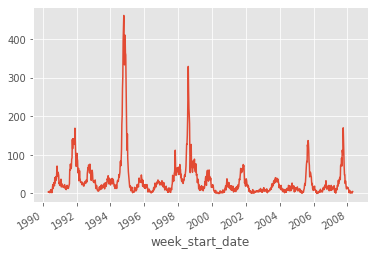

In [152]:
series.plot();

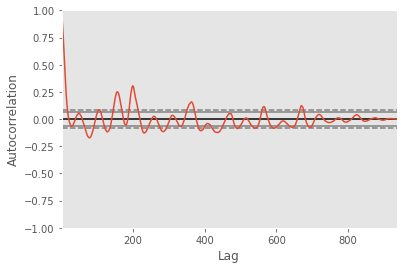

In [153]:
pd.plotting.autocorrelation_plot(series);

In [154]:
yt = series.diff()[1:]
yt.head()

week_start_date
1990-05-07    1.0
1990-05-14   -1.0
1990-05-21   -1.0
1990-05-28    3.0
1990-06-04   -4.0
Name: total_cases, dtype: float64

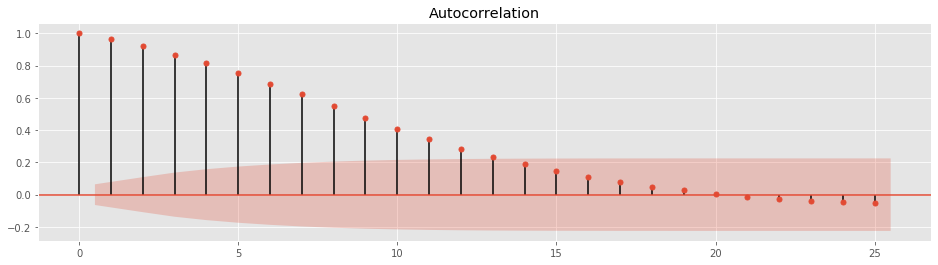

In [155]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(series, lags=25, ax=ax)

Autocorrelation is significant through week 8

## Seasonal Decomposition

In [156]:
decomposition = sm.tsa.seasonal_decompose(series, freq=52)

In [157]:
sm.__version__

'0.10.1'

In [158]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

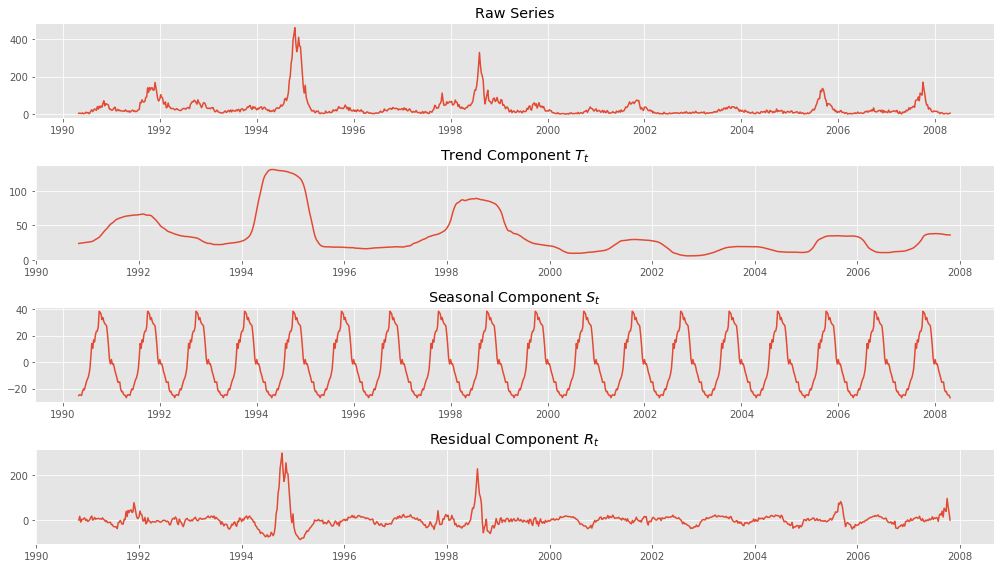

In [159]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, series, decomposition)
plt.tight_layout()